### Continuous Time Stochastic SIR Model

In this notebook, we will model the dynamics of the basic stochastic SIR model and investigate the affect of altering $\mathcal{R}_0$ has on the distribution of the total number of infecteds.

#### The Model

In this model, at time $t > 0$ we track the number of susceptible individuals $S(t)$, the number of infected individuals $I(t)$ and the number of recovered/immune individuals $R(t)$. The individuals within the constant population we are considering change according to the following iteractions
\begin{align}
     S + I &\rightarrow^{\beta} I + I \\
     I &\rightarrow^{\gamma} R     
\end{align}
where $\beta$ and $\gamma$ are the rates at which the events occur.

This model can be considered as a bivariate stochastic process with two discrete random variables $S(t)$ and $I(t)$. The process has the following transition probabilities


\begin{equation}
  p_{(s,i), \; (k,j)}=\begin{cases}
    \beta s i \frac{\Delta t}{N} + o(\Delta t), & \text{if $(k,j) = (s-1,j+1)$}.\\
    \gamma i \Delta t + o(\Delta t), & \text{if $(k,j) = (s, j-1)$}. \\
    1 - (\beta s i \frac{\Delta t}{N} + \gamma i \Delta t) + o(\Delta t), &\text{if $(k,j) = (s,j)$}. \\
    o(\Delta t) & \text{otherwise}.
  \end{cases}
\end{equation}

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# Basic Time Homogeneous Gillespie Algorithm


def gillespie_algo(t_final, X_0, rates):
    
    #import numpy as np
    #import math
    
    def calc_a0(X, rates, return_all = True):
        a1 = calc_a1(X, rates[0])
        a2 = calc_a2(X, rates[1])
        if return_all:
            return a1+a2, [a1, a2]
        else:
            return a1+a2
    
    def calc_a1(X, k):
        # transmition propensity: \beta S*I/N
        return k*X[0]*X[1] 
    
    def calc_a2(X, k):
        return k*X[1]
    
    def v1():
        # transmition, S + I -> I + I
        return np.array((-1, +1, 0))
    
    def v2():
        # recovery, I -> R
        return np.array((0, -1, +1))
    
    S = X_0[0]
    I = X_0[1]
    R = X_0[2]
    N = np.sum(X_0)
    
    [beta, gamma] = rates
    beta = beta/N
    
    t = 0
    state_hist = []
    t_hist = []
    
    prop_fns = {0:v1, 1:v2}
    
    X = np.asarray(X_0)
    
    state_hist.append(X)
    t_hist.append(0)
    
    while t <= t_final:
        # calculate a_0
        a_0, a_list = calc_a0(X, [beta, gamma])
        #print("Propensities: a1 = "+ str(a_list[0]) + ", a2 = " + str(a_list[1]))
        # generate a reaction time
        r1 = np.random.rand()
        tau = math.log(1/r1) / (a_0)
        t += tau
        # choose a reaction
        r2 = np.random.rand()
        for idx in range(len(a_list)):
            #print("a_i: " + str(np.sum(a_list[:idx + 1])))
            if r2*a_0 < np.sum(a_list[:idx +1]):
                reaction_idx = idx
                break
            elif idx == (len(a_list) - 1):
                reaction_idx = idx
        # update state vector
        X = X + prop_fns[reaction_idx]()
        state_hist.append(X)
        t_hist.append(t)
    return t_hist, state_hist

In [3]:
t_hist, state_hist = gillespie_algo(50, [4997, 1, 0], [2, 1])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


In [4]:
S = [item[0] for item in state_hist]
I = [item[1] for item in state_hist]
R = [item[2] for item in state_hist]

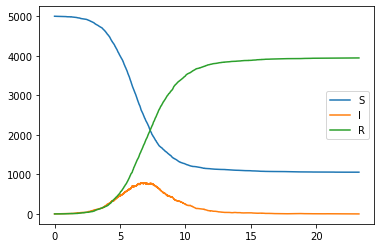

In [5]:
plt.plot(t_hist, S)
plt.plot(t_hist, I)
plt.plot(t_hist, R)
plt.legend(["S", "I", "R"])

plt.show()

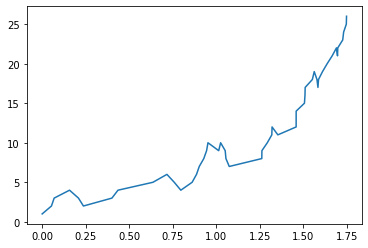

In [6]:
plt.plot(t_hist[:50], I[:50])

In [9]:
# Comparing multiple simulations to the deterministic SIR dynamics

t_hists = {}
S_hists = {}
I_hists = {}
R_hists = {}

for i in range(7):
    t_hist, state_hist = gillespie_algo(50, [4999, 1, 0], [2, 1])
    S = [item[0] for item in state_hist]
    I = [item[1] for item in state_hist]
    R = [item[2] for item in state_hist]
    t_hists[i] = t_hist
    S_hists[i] = S
    I_hists[i] = I
    R_hists[i] = R

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


(0, 5)

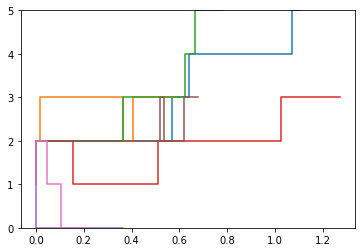

In [10]:
f, ax = plt.subplots()

for i in I_hists:
    ax.plot(t_hists[i][:5], I_hists[i][:5], drawstyle = "steps-pre")
    
ax.set_ylim([0, 5])

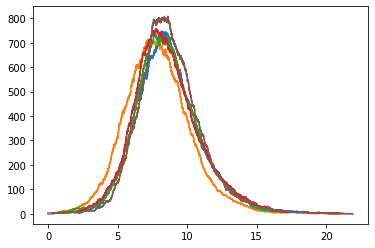

In [11]:
f, ax = plt.subplots()

for i in I_hists:
    ax.plot(t_hists[i], I_hists[i], drawstyle = "steps-pre")

#### Duration of an Epidemic

We now wish to run multiple simulations of the model to find a probability distribution for the time taken for the epidemic to become extinct. We will repeat these simulations and observe the affect of changing $\mathcal{R}_0$ has on this distribution. A priori, we should expect a bimodal-esque distribution for certain $\mathcal{R}_0$. In the beginning, when the number of infecteds is small, we should see some extinctions due to the stochastic nature of model, whilst for the simulations that manage to survive the initial period, we may see the infection take hold of the population - thus giving a potential bimodal distribution.

In [60]:
# running multiple simulations

r_list = [0.9, 1.1, 2, 3.5]

r_hist = {}

for r_0 in r_list:
    # test different R_0 values
    
    r_hist[r_0] = {}
    t_hists = {}
    S_hists = {}
    I_hists = {}
    R_hists = {}
    
    for i in range(5000):
        t_hist, state_hist = gillespie_algo(50, [4999, 1, 0], [r_0, 1])
        S = [item[0] for item in state_hist]
        I = [item[1] for item in state_hist]
        R = [item[2] for item in state_hist]
        t_hists[i] = t_hist
        S_hists[i] = S
        I_hists[i] = I
        R_hists[i] = R
        
    r_hist[r_0]["S"] = S_hists
    r_hist[r_0]["I"] = I_hists
    r_hist[r_0]["R"] = R_hists
    r_hist[r_0]["t"] = t_hists
    print("Completed R_0: " + str(r_0))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Completed R_0: 0.9
Completed R_0: 1.1
Completed R_0: 2
Completed R_0: 3.5


In [62]:
end_times = {}
unfinished = 0
for r_0 in r_hist:
    end_times[r_0] = []
    for i in r_hist[r_0]["I"]:
        if 0 in r_hist[r_0]["I"][i]:
            end_idx = len( r_hist[r_0]["I"][i]) - 2
            end_times[r_0].append(r_hist[r_0]["t"][i][end_idx])
        else:
            unfinished+=1

Text(0, 0.5, 'Density Estimate')

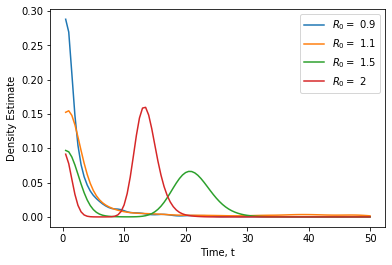

In [64]:
from scipy import stats

positions = np.linspace(0, 50, 101)
kernels = {}
estimates = {}

for r_0 in r_list:
    kernels[r_0] = stats.gaussian_kde(end_times[r_0])
    estimates[r_0] = kernels[r_0](positions[1:])

plt.plot(positions[1:], estimates[0.9])
plt.plot(positions[1:], estimates[1.1])
plt.plot(positions[1:], estimates[2])
plt.plot(positions[1:], estimates[3.5])
plt.legend(["$R_0 =$ 0.9", "$R_0 =$ 1.1", "$R_0 =$ 1.5", "$R_0 =$ 2"])
plt.xlabel("Time, t")
plt.ylabel("Density Estimate")

In [65]:
# unfinished

117

### Probability of a Major Epidemic

If we let $q_1$ denote the probability of no major epidemic in our SIR model given one initial infective, and we approximate the dynamics of our system to be a branching process, we obtain the following relation.
$$
q_1 = \mathbb{P}(\text{infective infects susceptible})q_2 + \mathbb{P}(\text{infective removal before infecting})q_0
$$
Since the probability of no major epidemic with zero infectives is 1, $q_1 = 1$. We also make a simiplification in out branching process, assuming that the lineages of infective individuals are independent, that is $q_2 = q_1^2$ or more generally, $q_k = q_1^k$. Substituting in the probability of infection and removal respectively, we obtain the following quadratic
$$
0 = \frac{\beta}{\gamma + \beta}q_1^2 - q_1 + \frac{\gamma}{\gamma + \beta}
$$
which has solutions, $q_1 = 1$ and $q_1 = \frac{\gamma}{\beta}$. By arguing through the use of PGFs and branching processes, we take the minimum of the two solutions as the probability of no epidemic.

The probability of a major epidemic from one initial infective is therefore
\begin{equation}
  1 - q_1 = 
  \begin{cases}
      0 \quad \text{if } \mathcal{R}_0 < 1 \\
      1 - \frac{1}{\mathcal{R}_0} \quad \text{if } \mathcal{R}_0 > 1 .\\
  \end{cases}
\end{equation}

In [66]:
r_list

[0.9, 1.1, 2, 3.5]

In [67]:
# Finding lineages which we classify as Major Epidemics vs Minor

# We say an epidemic is Major if the total number of infected over the duration of the epidemic was more than 20. 

major_epi = {}
major_epi_threshold = 200

for r_0 in r_list:
    major_epi[r_0] = []
    for i in range(len(r_hist[r_0]["R"])):
        total_infec = r_hist[r_0]["R"][i][-1]
        if total_infec >  major_epi_threshold:
            major_epi[r_0].append(1)
        else:
            major_epi[r_0].append(0)

In [68]:
# Working out probabilities of Major epidemics from simulations

for r_0 in r_list:
    major = np.sum(major_epi[r_0])
    total_sims = len(major_epi[r_0])
    print("="*100)
    print("R_0: "+ str(r_0))
    print("Simulation Probability: " + str(major / total_sims))
    print("Analytical Probability: " + str(max(0, 1- 1/r_0)))
print("="*100)

R_0: 0.9
Simulation Probability: 0.007
Analytical Probability: 0
R_0: 1.1
Simulation Probability: 0.092
Analytical Probability: 0.09090909090909094
R_0: 2
Simulation Probability: 0.5068
Analytical Probability: 0.5
R_0: 3.5
Simulation Probability: 0.7288
Analytical Probability: 0.7142857142857143


In [75]:
# Final size bi-modality


r_0 = 2
final_size = []
for i in range(len(r_hist[r_0]["R"])):
    final_size.append( r_hist[r_0]["R"][i][-1] )

(array([2466.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    7.,
        2527.]),
 array([2.0000e+00, 4.2170e+02, 8.4140e+02, 1.2611e+03, 1.6808e+03,
        2.1005e+03, 2.5202e+03, 2.9399e+03, 3.3596e+03, 3.7793e+03,
        4.1990e+03]),
 <a list of 10 Patch objects>)

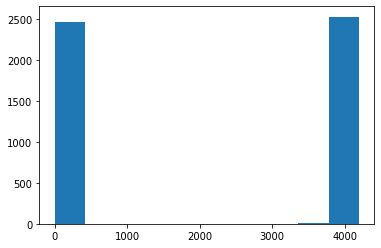

In [76]:
plt.hist(final_size)

## Checking Branching Process Approximation vs Simulations

In [12]:
b_grid = np.linspace(0.5, 2, 10)
m_grid = np.linspace(0.5, 2, 10)

from mpl_toolkits import mplot3d
from matplotlib import cm

def f(beta, mu):
    return np.minimum(1, mu/beta)


x = np.linspace(0.5, 2.0)
y = np.linspace(0.5, 2.0)
X, Y = np.meshgrid(x, y)
zs = np.array(f(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

z = f(b_grid, m_grid)

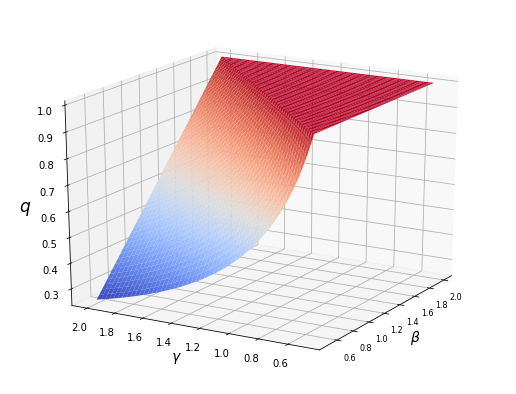

In [16]:
b_grid2 = np.linspace(0.5, 2)
m_grid2 = np.linspace(0.5, 2)

Z = np.zeros((len(b_grid2), len(m_grid2)))

for i in range(len(b_grid2)):
    for j in range(len(m_grid2)):
        Z[i,j] = np.minimum(1, m_grid2[j] / b_grid2[i])
        
fig = plt.figure(figsize = (9,7))
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')
ax.xaxis.set_rotate_label(False) 
ax.yaxis.set_rotate_label(False)

B2, M2 = np.meshgrid(b_grid2, m_grid2)

ax.plot_surface(B2, M2, Z, cmap = cm.coolwarm, alpha = 1)
ax.set_xlabel("$\\beta$", fontsize = 14)
ax.set_ylabel("$\gamma$", fontsize = 14)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.set_zlabel("$q$", fontsize = 17)
ax.view_init(20, 210)

#plt.savefig("imgs/analytic_prob_3d.pdf", bbox_inches = "tight")

In [478]:
# running multiple simulations

F = 100

r_hist = {}

for b in b_grid:
    r_hist[b] ={}
    for m in m_grid:
        # test different R_0 values

        r_hist[b][m] = 0
        R_hists = {}

        for i in range(750):
            t_hist, state_hist = gillespie_algo(50, [4999, 1, 0], [b, m])
            R = [item[2] for item in state_hist]
            if R[-1] > F:
                r_hist[b][m] += 1

        r_hist[b][m] = r_hist[b][m] / 750
        
        
        #print("Completed R_0: " + str(b) + " " + str(m))
    print("Completed b: " + str(b))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars


Completed b: 0.5
Completed b: 0.6666666666666666
Completed b: 0.8333333333333333
Completed b: 1.0
Completed b: 1.1666666666666665
Completed b: 1.3333333333333333
Completed b: 1.5
Completed b: 1.6666666666666665
Completed b: 1.8333333333333333
Completed b: 2.0


In [505]:
Z_hat = np.zeros((len(b_grid), len(m_grid)))
Z = np.zeros((len(b_grid), len(m_grid)))

for i in range(len(b_grid)):
    for j in range(len(m_grid)):
        Z_hat[i,j] = 1 - r_hist[b_grid[i]][m_grid[j]]
        Z[i,j] = np.minimum(1, m_grid[j] / b_grid[i])

In [546]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

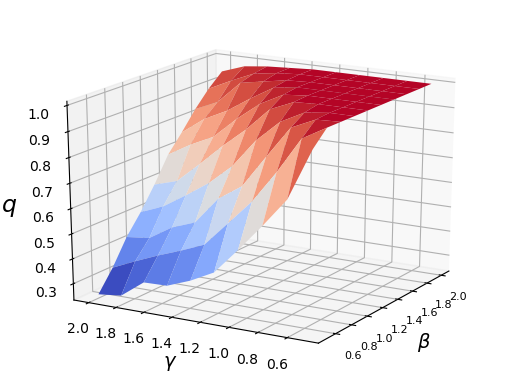

In [563]:
B, M = np.meshgrid(b_grid, m_grid)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.xaxis.set_rotate_label(False) 
ax.yaxis.set_rotate_label(False) 
#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.plot_surface(B, M, Z_hat, cmap = cm.coolwarm)
ax.set_xlabel(r'$ \beta $', fontsize = 14)
ax.set_ylabel("$\gamma$", fontsize = 14)
ax.set_zlabel("$q$", fontsize = 17)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.view_init(20, 210)

#plt.savefig("imgs/simulation_prob_3d.pdf", bbox_inches = "tight")